# Analyse et Prévision de Séries Chronologiques de la Production Électrique avec Python

## Introduction 

>La production d'électricité est un indicateur clé pour comprendre la dynamique énergétique d'un pays ou d'une région. Analyser son évolution au fil du temps permet d'identifier des tendances, des cycles saisonniers et des anomalies qui peuvent avoir un impact significatif sur la gestion énergétique.

>Ce projet vise à explorer et modéliser les données mensuelles de production d'électricité en utilisant des techniques d'analyse de séries chronologiques. L'objectif principal est de comprendre le comportement de la production au fil du temps et de mettre en place des modèles de prévision fiables.

## Analyse et explorations des données 

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

L'importation des bibliothèques est terminée, nous passons maintenant à la préparation et l'exploration des données.

In [142]:
df = pd.read_csv("Electric_Production.csv", sep=",")
df["DATE"] = pd.to_datetime(df["DATE"], format="%m/%d/%Y")
df.rename(columns={'IPG2211A2N': 'Production'}, inplace=True)
df.set_index("DATE", inplace=True)
df = df.asfreq('MS')
print(df.head())


            Production
DATE                  
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


La série chronologique ne contient aucune valeur manquante 

### Analyse des valeurs extrêmes de la production électrique

In [146]:
df.describe()

,Production
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


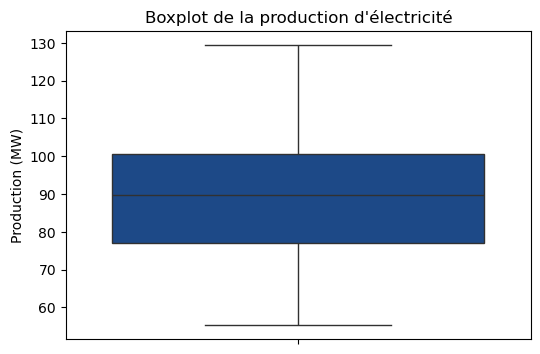

In [147]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df["Production"], color="#0B4699")
plt.title("Boxplot de la production d'électricité")
plt.ylabel("Production (MW)")
plt.show()


>Le boxplot de la production électrique montre une répartition stable des données entre 55 MW et 130 MW, avec une médiane autour de 90 MW. La distribution est équilibrée sans valeurs aberrantes apparentes, indiquant l'absence de fluctuations extrêmes. Les pics élevés correspondent probablement à des périodes de forte demande, tandis que les valeurs basses reflètent des périodes de moindre activité. Aucune correction n'est nécessaire, toutes les données seront conservées pour la modélisation. Passons maintenant à la division des données en ensembles d'entraînement et de test.


In [149]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

print("Taille d'entraînement :", train.shape)
print("Taille de test :", test.shape)


Taille d'entraînement : (317, 1)
Taille de test : (80, 1)


>Nous avons divisé les données en ensembles d'entraînement et de test afin d'évaluer la performance des modèles prédictifs sur des données inédites et garantir leur capacité de généralisation.

## Visualisation de la série 

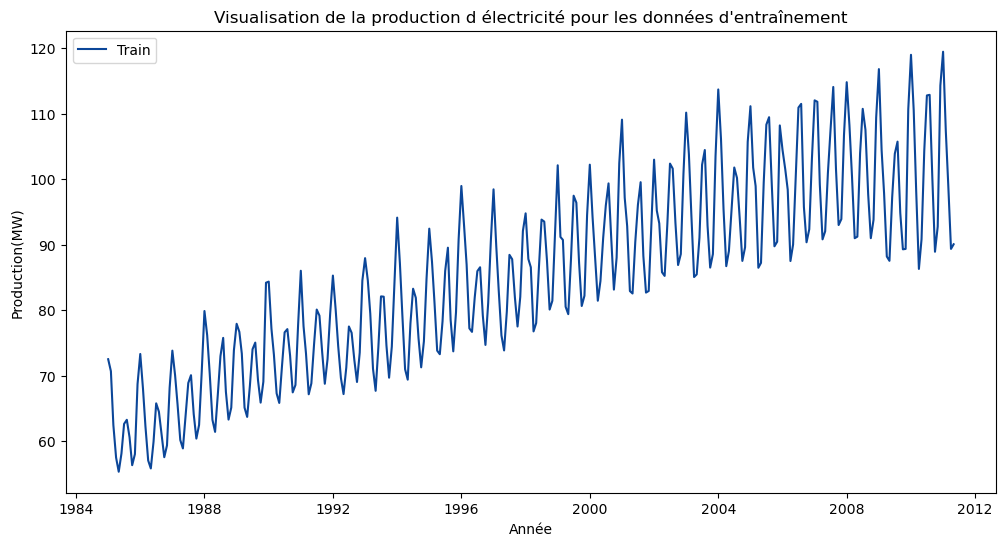

In [152]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train["Production"], color='#0B4699', label="Train")
plt.xlabel("Année")
plt.ylabel("Production(MW)")
plt.title("Visualisation de la production d électricité pour les données d'entraînement")
plt.legend()
plt.show()


### Analyse visuelle de la série temporelle de la production d'électricité
**1. Tendance générale :**
>La courbe représentant l'évolution de la production d'électricité entre 1985 et 2011 révèle plusieurs caractéristiques importantes. Tout d'abord, on observe une tendance générale haussière sur l'ensemble de la période. La production d'électricité passe d'environ 70 MW en 1985 à plus de 120 MW en 2011, illustrant une augmentation progressive de la demande énergétique ou une amélioration des capacités de production.

**2. Saisonnalité :**
>En parallèle, la série présente une saisonnalité marquée avec des motifs récurrents chaque année. Les pics et creux observés à intervalles réguliers sont probablement liés à des variations saisonnières de la demande en électricité. Cette régularité saisonnière est un indicateur clé pour la modélisation future.

**3. Volatilité & Absence de valeurs aberrantes  :**
>Concernant la volatilité, la variabilité entre les périodes hautes et basses reste relativement constante au fil des années. Aucun changement majeur dans l'amplitude des fluctuations n'est visible, ce qui suggère une saisonnalité stable et prévisible. De plus, aucune valeur aberrante n'est détectée dans la série ; les fluctuations suivent un motif régulier sans pics isolés ou anomalies marquantes.

**Conclusion :**
>En conclusion, la série temporelle est marquée par une tendance haussière et une saisonnalité régulière, rendant la série non stationnaire. Avant de procéder aux tests de stationnarité et à la modélisation, la prochaine étape consistera à décomposer la série temporelle en ses différentes composantes : tendance, saisonnalité et résidus.

## La décomposition de la série 

Une série temporelle est composée de trois éléments principaux :  

- **Tendance**  : L’évolution à long terme des données (hausse, baisse ou stabilité).  
- **Saisonnalité**  : Les fluctuations périodiques qui reviennent à intervalles réguliers.  
- **Résidu**  : Les variations aléatoires imprévisibles.  

On distingue deux types de modèles pour la décomposition :  

- **Modèle additif** : Utilisé lorsque l’amplitude des variations saisonnières reste constante.$$y(t) = Niveau + Tendance + Saisonnalité + Bruit$$
- **Modèle multiplicatif** : Utilisé lorsque l’amplitude des variations saisonnières change proportionnellement à la tendance.$$y(t) = Niveau * Tendance * Saisonnalité * Bruit$$ 

Dans notre cas, la saisonnalité reste stable au fil du temps, ce qui justifie l’utilisation du **modèle additif**.


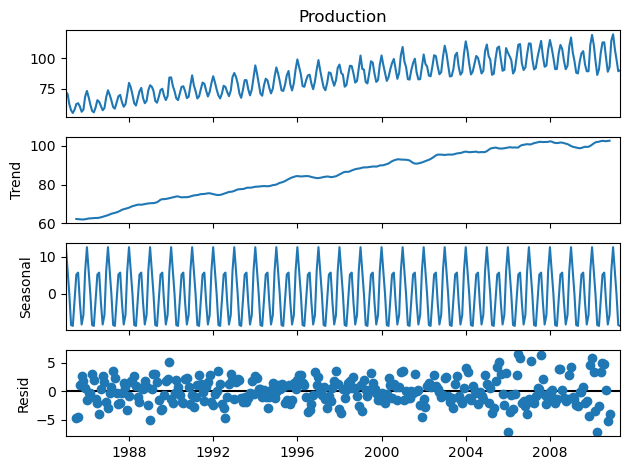

In [156]:
decomposed = seasonal_decompose(train["Production"], model='additive', period=12) 
decomposed.plot()
plt.show()


>Maintenant que nous avons décomposé la série en tendance, saisonnalité et résidu, nous allons analyser chaque composante individuellement pour mieux comprendre son impact sur la production de l électricité.

## Etude des composantes de la série 

### **La tendance**

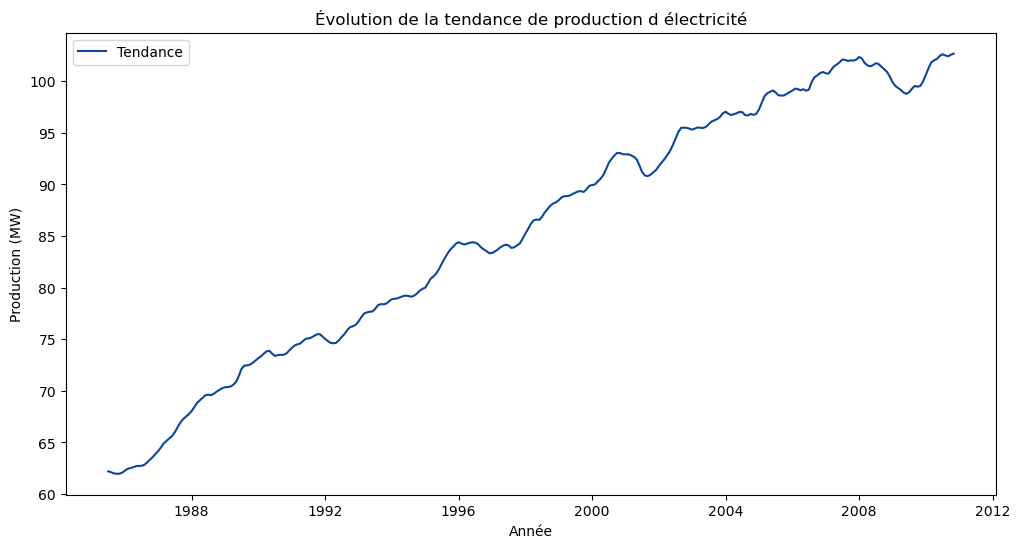

In [160]:
plt.figure(figsize=(12,6))
plt.plot(decomposed.trend, color='#0B4699', label="Tendance")
plt.xlabel("Année")
plt.ylabel("Production (MW)")
plt.title("Évolution de la tendance de production d électricité")
plt.legend()
plt.show()


>On observe une croissance régulière de la production d'électricité au fil du temps, marquée par une trajectoire ascendante. Cette tendance indique une augmentation progressive et soutenue de la production sur l'ensemble de la période.

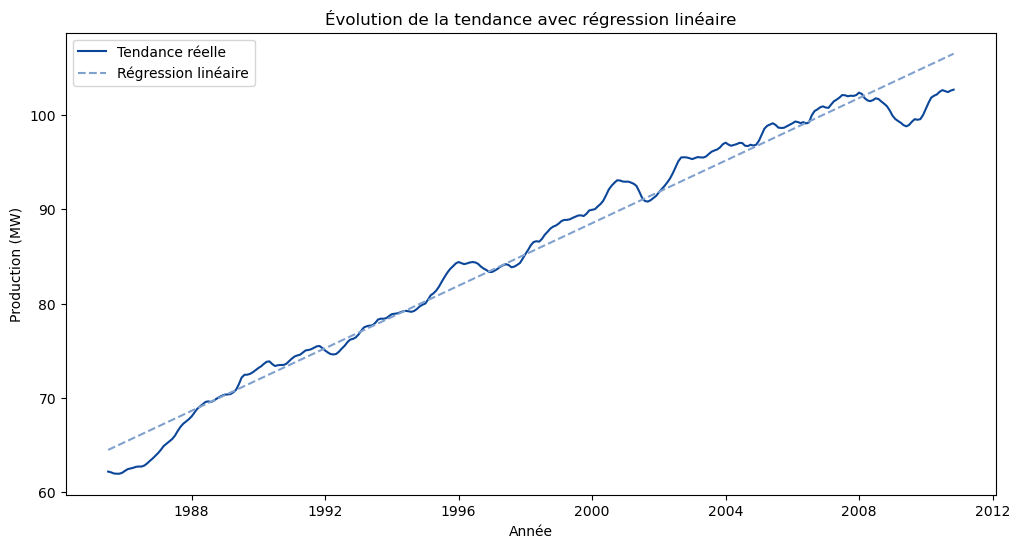

In [162]:
from scipy.stats import linregress
trend_data = decomposed.trend.dropna()
x_values = trend_data.index.astype('int64') // 10**9 
slope, intercept, r_value, p_value, std_err = linregress(x_values, trend_data.values)
# voici la ligne de tendance prédite
trend_line = intercept + slope * x_values

plt.figure(figsize=(12,6))
plt.plot(trend_data.index, trend_data.values, label="Tendance réelle", color='#0B4699')
plt.plot(trend_data.index, trend_line, label="Régression linéaire", color='#80A1CE', linestyle="dashed")
plt.xlabel("Année")
plt.ylabel("Production (MW)")
plt.title("Évolution de la tendance avec régression linéaire")
plt.legend()
plt.show()


>La droite de régression souligne une progression linéaire de la tendance, confirmant l'augmentation constante de la production. Les écarts entre la courbe réelle et la régression restent limités, validant la stabilité de la tendance haussière.

### **La saisonnalité**

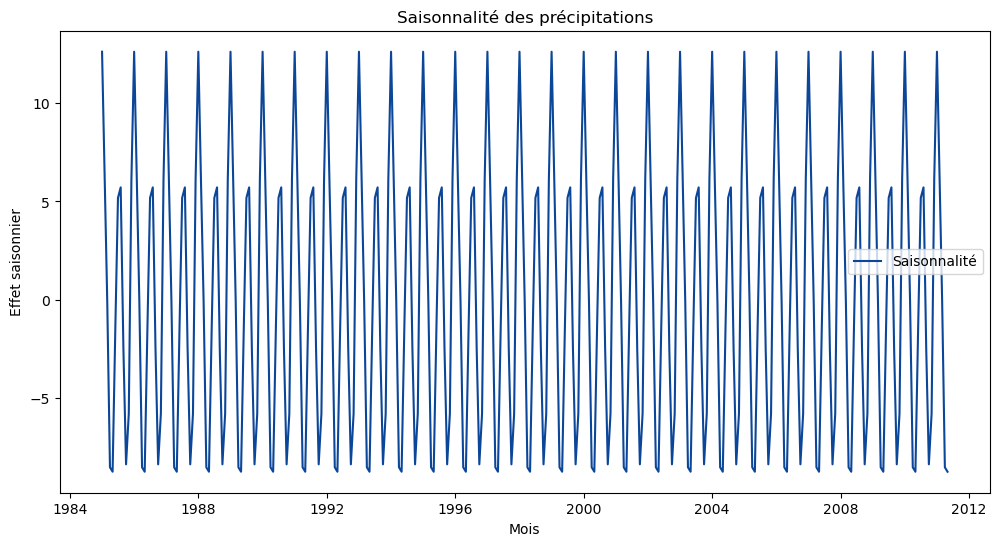

In [165]:
plt.figure(figsize=(12,6))
plt.plot(decomposed.seasonal, color='#0B4699', label="Saisonnalité")
plt.xlabel("Mois")
plt.ylabel("Effet saisonnier")
plt.title("Saisonnalité des précipitations")
plt.legend()
plt.show()


>La saisonnalité suit un cycle annuel régulier, avec des fluctuations récurrentes chaque année. Les variations montrent des pics et des creux constants, soulignant une influence saisonnière stable sur la production d'électricité.

### **Les résidus**

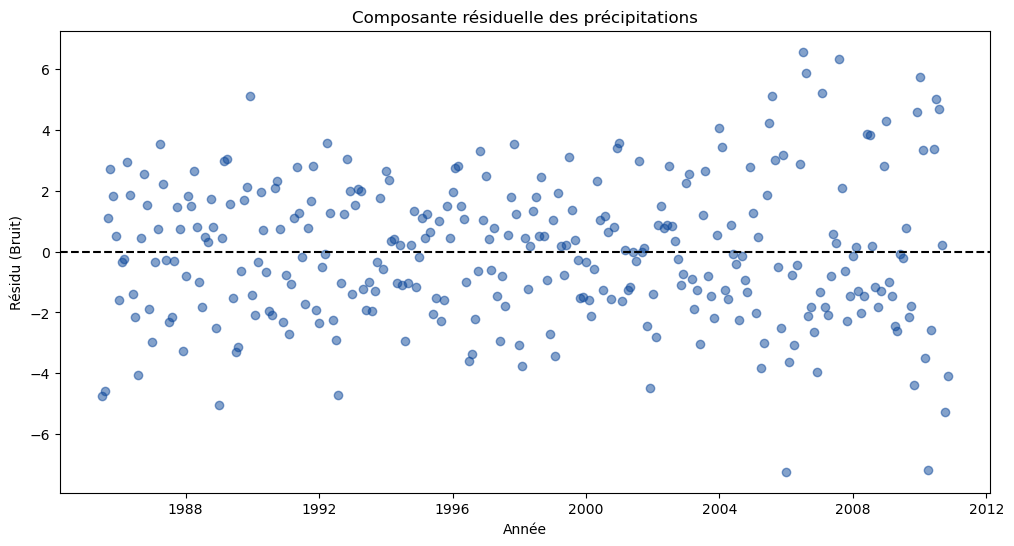

In [168]:
plt.figure(figsize=(12,6))
plt.scatter(decomposed.resid.index, decomposed.resid, color='#0B4699', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xlabel("Année")
plt.ylabel("Résidu (Bruit)")
plt.title("Composante résiduelle des précipitations")
plt.show()


>Les résidus sont dispersés autour de la ligne zéro sans motif clair, indiquant l'absence de tendance ou de saisonnalité résiduelle. Leur distribution aléatoire suggère que le modèle capte correctement la structure principale de la série temporelle, laissant uniquement du bruit aléatoire.

## **La stationnarité**

### **La stationnarité d’une série temporelle et le test de Dickey-Fuller**  

>La stationnarité d’une série temporelle est essentielle pour une modélisation fiable. Une série est dite stationnaire lorsque ses statistiques principales, comme la moyenne, la variance et l’autocorrélation, restent constantes dans le temps. Cela signifie qu’elle ne présente pas de tendance marquée ni de variations saisonnières importantes, ce qui la rend plus facile à analyser et à modéliser.
### **Hypothèses du test ADF**

>Pour vérifier la stationnarité d’une série, on utilise le test de Dickey-Fuller Augmenté (ADF). Ce test statistique permet de détecter la présence d’une racine unitaire, un indicateur de non-stationnarité. Le test repose sur deux hypothèses : l’hypothèse nulle (H₀), qui suppose que la série est non stationnaire, et l’hypothèse alternative (H₁), qui indique que la série est stationnaire. 

### **Interprétation du test ADF**  

>L’interprétation des résultats du test ADF se fait en analysant la p-valeur. Si cette dernière est inférieure à 0,05, on rejette l’hypothèse nulle et on conclut que la série est stationnaire. En revanche, si la p-valeur est supérieure ou égale à 0,05, on ne peut pas rejeter l’hypothèse nulle, ce qui indique que la série est non stationnaire et nécessite une transformation, comme une différenciation, avant toute analyse plus approfondie.

In [172]:
# Appliquation du test ADF
from statsmodels.tsa.stattools import adfuller
result = adfuller(train["Production"])
print(f"Statistique de test ADF : {result[0]}")
print(f"P-valeur : {result[1]}")

if result[1] < 0.05:
    print("La série est stationnaire")
else:
    print("La série n'est pas stationnaire")


Statistique de test ADF : -1.7386950117875162
P-valeur : 0.41129393445577356
La série n'est pas stationnaire


>La statistique de test ADF obtenue est de -1.74 avec une p-valeur de 0.41. Étant donné que la p-valeur est largement supérieure au seuil critique de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle.

## Différenciation

>La **différenciation** est une technique courante en analyse de séries temporelles qui consiste à calculer la différence entre des observations consécutives d'une série. Elle est principalement utilisée pour stabiliser la moyenne d'une série temporelle en éliminant les tendances et les composantes saisonnières, rendant ainsi la série **stationnaire**.

**Pourquoi utiliser la différenciation ?**:

>**Stabilisation de la moyenne** : Une série non stationnaire présente souvent une tendance croissante ou décroissante au fil du temps. La différenciation supprime ces tendances pour stabiliser la moyenne.
**Préparation pour les modèles ARIMA** : Les modèles ARIMA nécessitent une série stationnaire. La différenciation permet de transformer une série non stationnaire pour répondre à cette exigence.
**Réduction de la variance** : En éliminant les fluctuations systématiques, la différenciation aide à obtenir une série avec une variance plus stable.


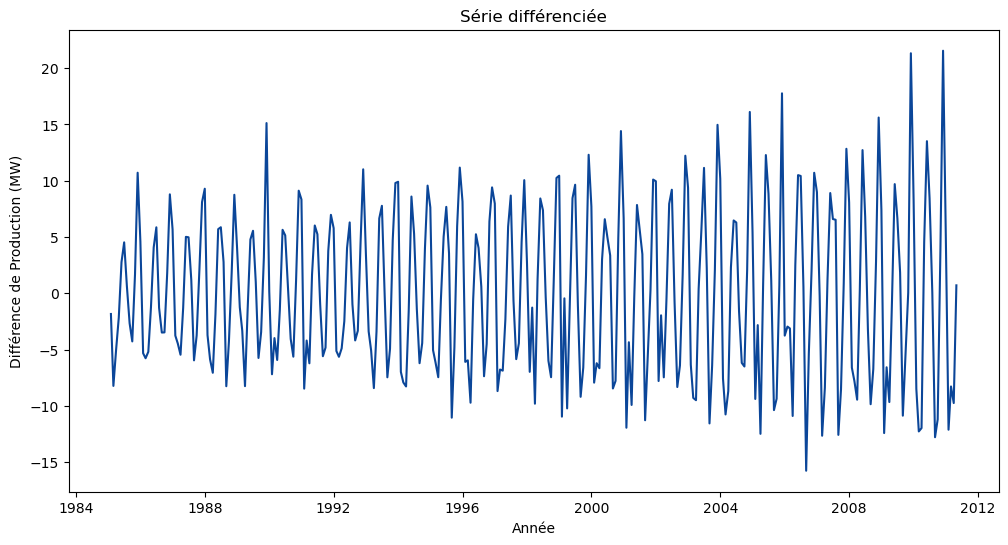

In [176]:
diff_series = train["Production"].diff().dropna()
plt.figure(figsize=(12,6))
plt.plot(diff_series, color='#0B4699')
plt.title("Série différenciée")
plt.xlabel("Année")
plt.ylabel("Différence de Production (MW)")
plt.show()


>La série différenciée montre les variations mensuelles de la production d'électricité par rapport au mois précédent. On observe une réduction de la tendance initiale et une concentration des valeurs autour de zéro, bien que certaines fluctuations importantes subsistent. Cette transformation est essentielle pour éliminer les effets de tendance et rendre la série plus stationnaire,Pour confirmer la stationnarité, un nouveau test ADF devrait être effectué sur cette série différenciée.

In [178]:
result = adfuller(diff_series)
print(f"Statistique de test ADF : {result[0]}")
print(f"P-valeur : {result[1]}")

if result[1] < 0.05:
    print("La série est maintenant stationnaire")
else:
    print("La série n'est toujours pas stationnaire")

Statistique de test ADF : -6.352997676450295
P-valeur : 2.5832755038270734e-08
La série est maintenant stationnaire


## **Les autocorrélations**

### Analyse exploratoire des autocorrélations : Lag Plot, ACF et PACF
**1-Lag Plot : Visualisation des dépendances temporelles**
>Après avoir rendu la série stationnaire, on utilise le Lag Plot pour visualiser les relations entre les valeurs actuelles et leurs décalages. Ce graphique permet d’évaluer si les données présentent des dépendances temporelles. Un nuage de points aléatoire indique l'absence de corrélation, tandis qu'un motif clair révèle une autocorrélation et suggère l'utilisation de modèles autorégressifs (AR). Cette étape aide à comprendre la structure de la série avant d'appliquer des analyses plus détaillées comme l'ACF et la PACF pour affiner la modélisation.










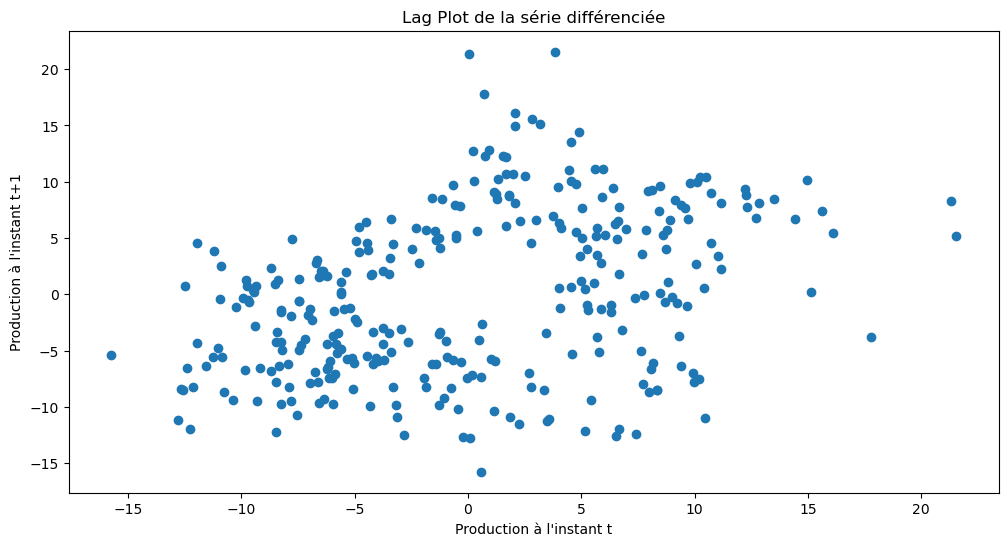

In [181]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,6))
lag_plot(diff_series)
plt.title("Lag Plot de la série différenciée")
plt.xlabel("Production à l'instant t")
plt.ylabel("Production à l'instant t+1")
plt.show()

>Le Lag Plot de la série différenciée révèle une autocorrélation positive entre les observations consécutives, indiquant une dépendance temporelle. Cette structure non aléatoire confirme l’existence de relations entre les valeurs passées et futures, justifiant l’utilisation de modèles autorégressifs pour la modélisation et la prévision de la série.

**2-Analyse des autocorrélations : ACF et PACF**  
>Après avoir examiné les dépendances temporelles via le Lag Plot, nous approfondissons l'analyse avec les fonctions ACF (Autocorrelation Function) et PACF (Partial Autocorrelation Function). Ces outils sont essentiels pour comprendre les corrélations dans les séries temporelles et déterminer les paramètres optimaux pour la modélisation.

>L'ACF mesure la corrélation entre une valeur et ses valeurs précédentes à différents décalages (lags), ce qui aide à identifier les modèles de moyenne mobile (MA). Une ACF où les barres diminuent lentement suggère une dépendance à long terme, tandis qu’une chute rapide vers zéro indique une mémoire courte.

>L'PACF, quant à elle, évalue l'effet direct d'une valeur passée sur la valeur actuelle, en éliminant l'influence des retards intermédiaires. Une ou plusieurs barres significatives suivies d’une chute rapide dans le PACF indiquent souvent un modèle autorégressif (AR).

>Ces analyses facilitent le choix des paramètres pour les modèles ARIMA :
p (ordre AR) est déterminé à partir du PACF,
q (ordre MA) est identifié grâce à l’ACF,
d (différenciation) est défini suite au test de stationnarité.
En combinant ces éléments, on peut sélectionner la structure la plus adaptée pour modéliser la série temporelle et améliorer la qualité des prévisions.

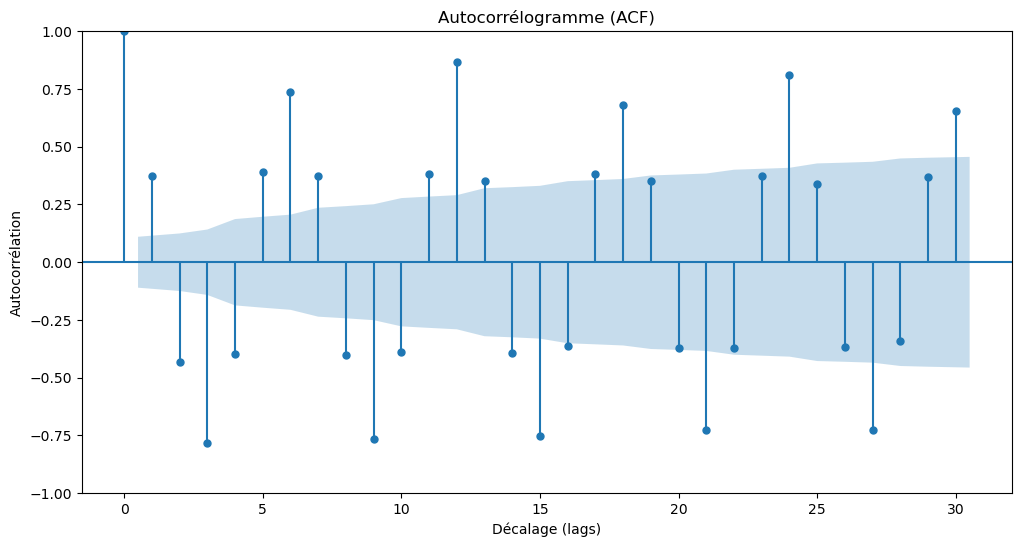

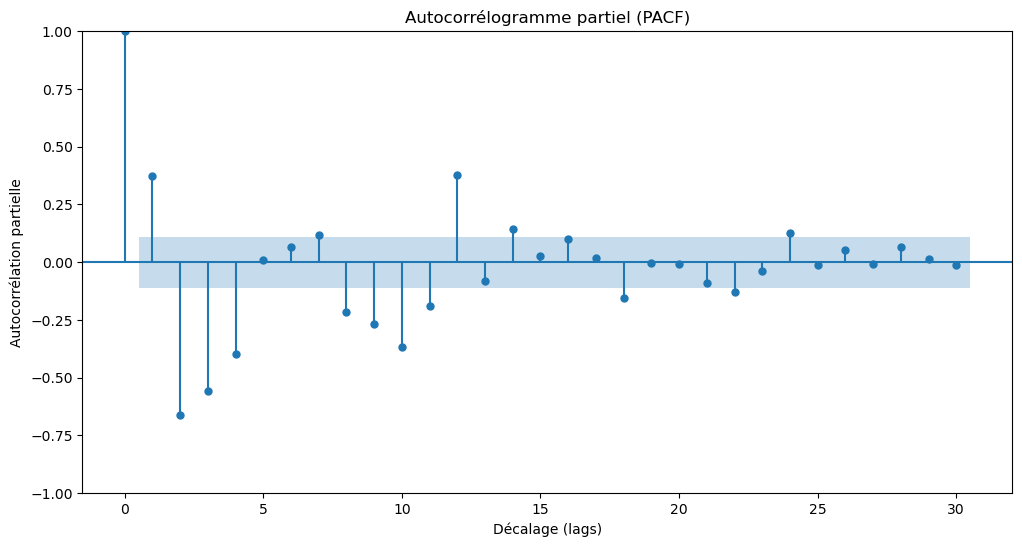

In [184]:
# ACF 
plt.figure(figsize=(12,6))
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("Autocorrélogramme (ACF)")
plt.xlabel("Décalage (lags)")
plt.ylabel("Autocorrélation")
plt.show()

# PACF
plt.figure(figsize=(12,6))
plot_pacf(diff_series, lags=30, method='ywm', ax=plt.gca())
plt.title("Autocorrélogramme partiel (PACF)")
plt.xlabel("Décalage (lags)")
plt.ylabel("Autocorrélation partielle")
plt.show()


## Résultats de l’analyse des autocorrélations  

>L'ACF montre comment les valeurs de la série temporelle sont liées à leurs valeurs passées. Dans ce graphique, on observe que plusieurs barres dépassent la zone bleue, ce qui signifie qu'il existe une corrélation entre les valeurs actuelles et celles décalées dans le temps. Cela indique que les données ne sont pas aléatoires et que les valeurs précédentes influencent les valeurs actuelles.


>Le PACF aide à comprendre la relation directe entre une valeur et ses valeurs passées, sans tenir compte des influences intermédiaires. On remarque un pic important au premier décalage, ce qui montre que la valeur actuelle dépend directement de la valeur précédente. Après ce premier décalage, les barres diminuent, indiquant moins de corrélation avec les autres valeurs passées.


## Modélisation des séries temporelles - Méthode Box-Jenkins
>La **méthode Box-Jenkins** est une approche systématique utilisée pour modéliser et prévoir les séries temporelles. Elle repose principalement sur l'utilisation des modèles **ARIMA** et ses variantes. Le processus comprend trois étapes clés : **l'identification**, **l'estimation** et **la validation** du modèle.les principaux modèles sont les suivants : **AR**, **MA**, **ARMA**, **ARIMA**, **SARIMA** et **SARIMAX**.
### Modèles AR & MA
>Les modèles **autorégressifs (AR)** et de **moyenne mobile (MA)** sont les bases des modèles de séries temporelles. Ils permettent de décrire un processus en fonction de ses valeurs passées et des erreurs précédentes.
#### Modèles autorégressifs (AR)
>Le modèle **AR(p)** suppose que la valeur actuelle d'une série temporelle dépend de ses **p** valeurs passées. C'est une régression de la série sur elle-même avec des décalages temporels,la
formule générale : 
  $ y_t = c + a_1 y_{t-1} + a_2 y_{t-2} + \dots + a_p y_{t-p} + e_t $

**Exemples :**  
>AR(1) : $ y_t = a_1 y_{t-1} + e_t $  
AR(2) : $ y_t = a_1 y_{t-1} + a_2 y_{t-2} + e_t $

**Interprétation :**  
  Plus les valeurs passées sont fortement corrélées avec la valeur actuelle, plus le modèle AR est efficace.
#### Modèles de moyenne mobile (MA)
>Le modèle **MA(q)** suppose que la valeur actuelle d'une série dépend des **q** erreurs aléatoires passées (termes de bruit blanc),la formule générale :
  $ y_t = c + e_t + m_1 e_{t-1} + m_2 e_{t-2} + \dots + m_q e_{t-q} $

**Exemples :**  
>MA(1) : $ y_t = e_t + m_1 e_{t-1} $  
MA(2) : $ y_t = e_t + m_1 e_{t-1} + m_2 e_{t-2} $

**Interprétation :**  
  Le modèle MA capture les chocs soudains dans la série en tenant compte des erreurs passées.
#### Modèle ARMA (Auto-Régressif + Moyenne Mobile)
>Le modèle **ARMA(p, q)** combine les concepts d'autorégression (**AR**) et de moyenne mobile (**MA**) pour modéliser une série temporelle stationnaire,la formule générale : 
  $ y_t = c + a_1 y_{t-1} + \dots + a_p y_{t-p} + e_t + m_1 e_{t-1} + \dots + m_q e_{t-q} $

**Exemple :**  
>ARMA(1,1) : $ y_t = a_1 y_{t-1} + m_1 e_{t-1} + e_t $

**Conditions :**  
  >Le modèle **ARMA** nécessite une série **stationnaire**. Si la série ne l’est pas, une différenciation est nécessaire (ARIMA).
#### Modèle SARIMA (ARIMA saisonnier)
>Le modèle **SARIMA (p, d, q) (P, D, Q, s)** est une extension d'**ARIMA** qui prend en compte les **composantes saisonnières**.
 **Paramètres supplémentaires :**  
  - **P** : ordre saisonnier AR  
  - **D** : degré de différenciation saisonnière  
  - **Q** : ordre saisonnier MA  
  - **s** : période saisonnière (ex : 12 pour des données mensuelles)
 **Formule générale :**  
  SARIMA combine les termes d'**ARIMA** et des composantes saisonnières pour modéliser les séries avec des cycles répétitifs.

#### Modèle SARIMAX (SARIMA avec variables exogènes)

>Le modèle **SARIMAX** est une extension de **SARIMA** qui permet d'intégrer des **variables exogènes** (informations externes) pour améliorer les prévisions.

**Utilisation :**  
  >Idéal si des facteurs externes influencent la série.


## **Modélisation du modèle SARIMA:**

>Pour modéliser et prévoir la production d'électricité, nous avons utilisé la méthode SARIMA (Seasonal AutoRegressive Integrated Moving Average), adaptée aux séries temporelles présentant des tendances et des composantes saisonnières. Le processus de sélection du meilleur modèle a été automatisé grâce à la fonction auto_arima de la librairie pmdarima, qui explore différentes combinaisons de paramètres pour minimiser le critère AIC (Akaike Information Criterion). Les paramètres évalués incluent les ordres d'auto-régression (p), de différenciation (d) et de moyenne mobile (q) ainsi que leurs équivalents saisonniers (P, D, Q) avec une périodicité (m) de 12 mois pour capturer les cycles annuels. Après plusieurs itérations, le modèle optimal sélectionné est SARIMA(1,1,1)(2,1,2)[12] avec un terme d'interception, offrant un AIC minimal de 1770.212.



In [190]:
pip install pmdarima


Note: you may need to restart the kernel to use updated packages.


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2010.162, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1940.101, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1835.298, Time=0.49 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1972.417, Time=0.18 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1836.547, Time=0.81 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1835.973, Time=3.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1923.364, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1835.172, Time=2.03 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1814.635, Time=4.71 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1823.212, Time=2.10 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1852.611, Time=3.54 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=1770.670, Time=6.45 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1785.329, Time=4.44 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=1773.643, Time=3.69 sec
 ARIMA(1,1,1)(1,1,1

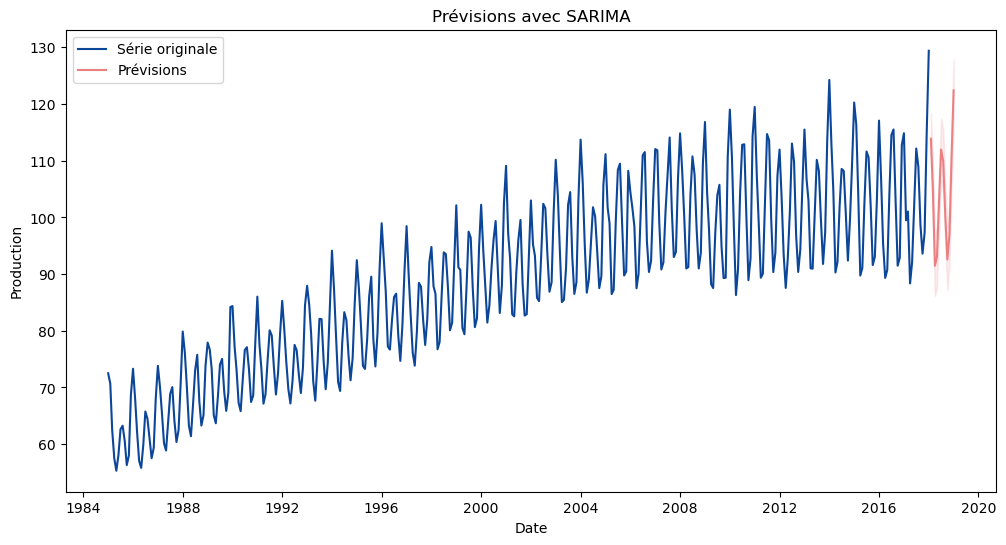

In [191]:
import pmdarima as pm
model = pm.auto_arima(df["Production"],
                      start_p=0, start_q=0,
                      max_p=5, max_q=5,
                      d=1,                      
                      seasonal=True,            
                      m=12,                     
                      D=1,                      
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2,
                      test='adf',              
                      trace=True,               
                      error_action='ignore',   
                      suppress_warnings=True,  
                      stepwise=True)         
print(model.summary())

n_periods = 12
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

forecast_index = pd.date_range(df.index[-1], periods=n_periods+1, freq='MS')[1:]

plt.figure(figsize=(12,6))
plt.plot(df["Production"], label='Série originale',color='#0B4699')
plt.plot(forecast_index, forecast, label='Prévisions', color='#EC8081')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='#F6BAC4', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Production")
plt.title("Prévisions avec SARIMA")
plt.legend()
plt.show()


## **Analyse des résultats et prévisions**

>Le modèle SARIMA(1,1,1)(2,1,2)[12]fournit une représentation précise des composantes saisonnières et non saisonnières de la série. Les termes AR(1) et MA(1) mettent en évidence une forte corrélation entre les valeurs passées et les erreurs, tandis que les composantes saisonnières (AR.S.L12 et MA.S.L12) capturent les motifs annuels répétitifs. Le test de Ljung-Box (dans l analyse des résidus )indique que les résidus ne présentent pas d'autocorrélations significatives (p-value = 0.77), suggérant un bon ajustement. Bien que le test de Jarque-Bera révèle une légère déviation de la normalité des résidus, les prévisions restent fiables. Le graphique des prévisions montre que le modèle suit bien la tendance et les motifs saisonniers, tout en fournissant des intervalles de confiance qui augmentent progressivement, reflétant l'incertitude des prévisions futures.



## Analyse des résidus

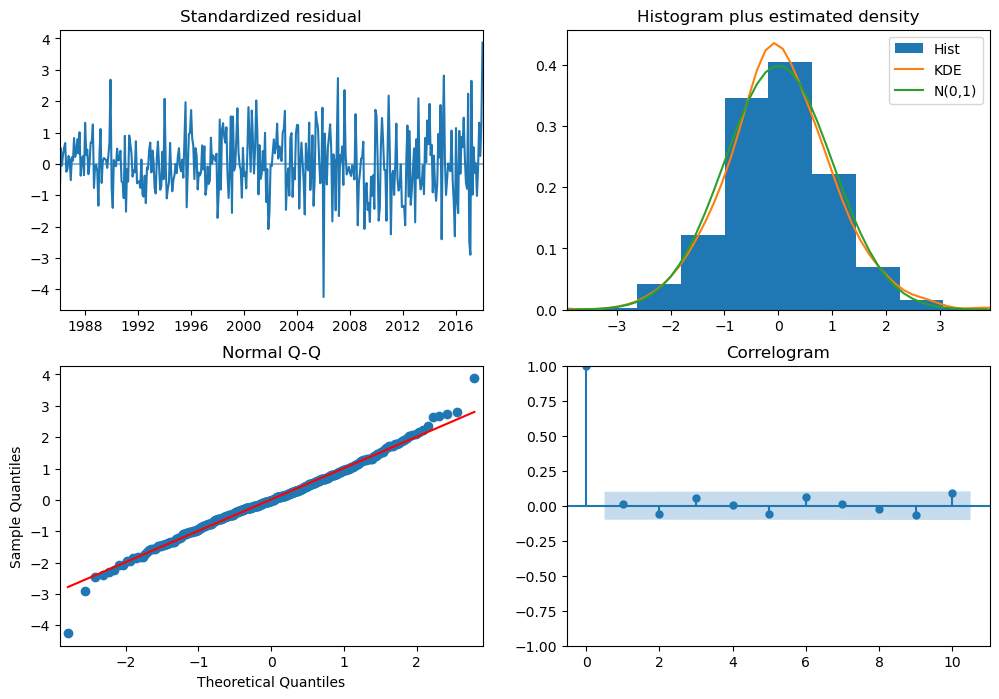

In [195]:
import statsmodels.api as sm
model.plot_diagnostics(figsize=(12,8))
plt.show()


>Les résidus du modèle montrent un bon ajustement. Ils oscillent autour de zéro sans motif clair, ce qui indique que le modèle a bien capturé les tendances des données. L'histogramme des résidus révèle une distribution proche de la normale, confirmée par la courbe KDE qui se superpose à la courbe théorique. Le graphique Q-Q montre que les résidus suivent globalement une distribution normale, avec de légers écarts en bout de courbe, ce qui reste acceptable. Enfin, le correlogramme indique que les résidus n'ont pas d'autocorrélations significatives, suggérant qu'ils se comportent comme un bruit blanc, ce qui est souhaitable pour un bon modèle.

### Test de Ljung-Box

In [198]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = model.resid()
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


     lb_stat  lb_pvalue
10  8.725781   0.558311


>Le test de Ljung-Box appliqué aux résidus donne une p-value de 0.5583 (> 0.05), ce qui signifie que nous n'avons pas assez de preuves pour rejeter l'hypothèse nulle d'absence d'autocorrélation dans les résidus. Cela confirme que le modèle est bien ajusté.



## Génération des Prévisions et Comparaison aux Données Réelles

>Après avoir ajusté le modèle SARIMA, nous avons généré des prévisions pour la période de test. Ces prévisions sont accompagnées d'intervalles de confiance pour évaluer l'incertitude. Un tableau a été créé pour comparer les valeurs réelles aux prévisions et vérifier la précision du modèle. 

In [202]:
n_periods = len(test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
results_df = pd.DataFrame({
    'Date': test.index,
    'Valeurs Réelles': test["Production"].values,
    'Prévisions': forecast,
    'Intervalle Inférieur': conf_int[:, 0],
    'Intervalle Supérieur': conf_int[:, 1]
})
results_df.set_index('Date', inplace=True)
print(results_df.head(10))


            Valeurs Réelles  Prévisions  Intervalle Inférieur  \
Date                                                            
2011-06-01         102.8204  113.879543            109.318175   
2011-07-01         114.7068  105.442008            100.255553   
2011-08-01         113.5958   91.479941             86.113867   
2011-09-01          99.4712   93.035066             87.608606   
2011-10-01          90.3566  102.876576             97.426178   
2011-11-01          93.8095  111.965309            106.503340   
2011-12-01         107.3312  109.933806            104.464943   
2012-01-01         111.9646  100.149875             94.676079   
2012-02-01         103.3679   92.587521             87.109684   
2012-03-01          93.5772   96.992001             91.510554   

            Intervalle Supérieur  
Date                              
2011-06-01            118.440911  
2011-07-01            110.628462  
2011-08-01             96.846014  
2011-09-01             98.461527  
2011-10-0

### Évaluation des Performances du Modèle

Pour évaluer la précision des prévisions,on a utilisé les métriques suivantes:
 
>MAE (Mean Absolute Error) : mesure l'erreur moyenne absolue entre les valeurs réelles et prédites, indiquant l'écart moyen en unités absolues.

 > RMSE (Root Mean Squared Error) : met davantage l'accent sur les grandes erreurs en élevant les écarts au carré avant de calculer la moyenne.

 > MAPE (Mean Absolute Percentage Error) : exprime l’erreur moyenne en pourcentage, facilitant l’interprétation quelle que soit l’échelle des données.

Ces métriques offrent une vue complète de la performance du modèle en termes d'exactitude et de cohérence des prévisions. Des erreurs faibles indiquent un modèle efficace.

In [205]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
y_true = results_df["Valeurs Réelles"]
y_pred = results_df["Prévisions"]

# les métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100 

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 13.76
Root Mean Squared Error (RMSE): 15.75
Mean Absolute Percentage Error (MAPE): 13.60%


  > Les métriques obtenues indiquent une performance satisfaisante du modèle SARIMA. Le MAE de 13.76 et le RMSE de 15.75 montrent des erreurs de prévision modérées, tandis que le MAPE de 13.60% indique que les prévisions s'écartent en moyenne de 13.6% des valeurs réelles, ce qui est acceptable pour des séries temporelles complexes.

### Comparaison des Valeurs Réelles et des Prévisions

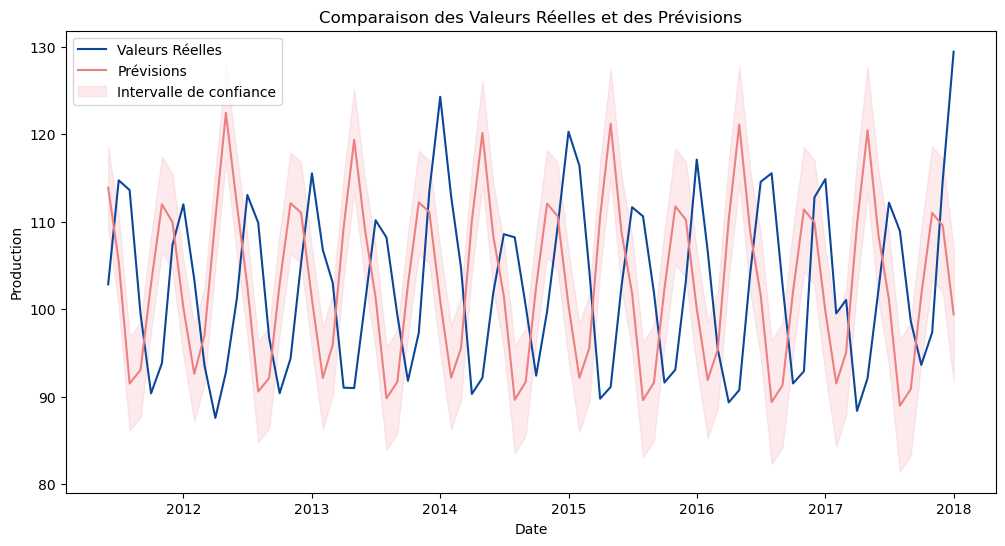

In [208]:
plt.figure(figsize=(12,6))
plt.plot(results_df.index, results_df["Valeurs Réelles"], label='Valeurs Réelles', color='#0B4699')
plt.plot(results_df.index, results_df["Prévisions"], label='Prévisions', color='#EC8081')
plt.fill_between(results_df.index, 
                 results_df["Intervalle Inférieur"], 
                 results_df["Intervalle Supérieur"], 
                 color='#F6BAC4', alpha=0.3, label='Intervalle de confiance')
plt.xlabel("Date")
plt.ylabel("Production")
plt.title("Comparaison des Valeurs Réelles et des Prévisions")
plt.legend()
plt.show()


>Les prévisions suivent globalement la tendance des données réelles, bien que des écarts soient visibles à certains moments. L'intervalle de confiance englobe la plupart des valeurs réelles, indiquant une bonne précision des prévisions tout en tenant compte de l'incertitude du modèle.


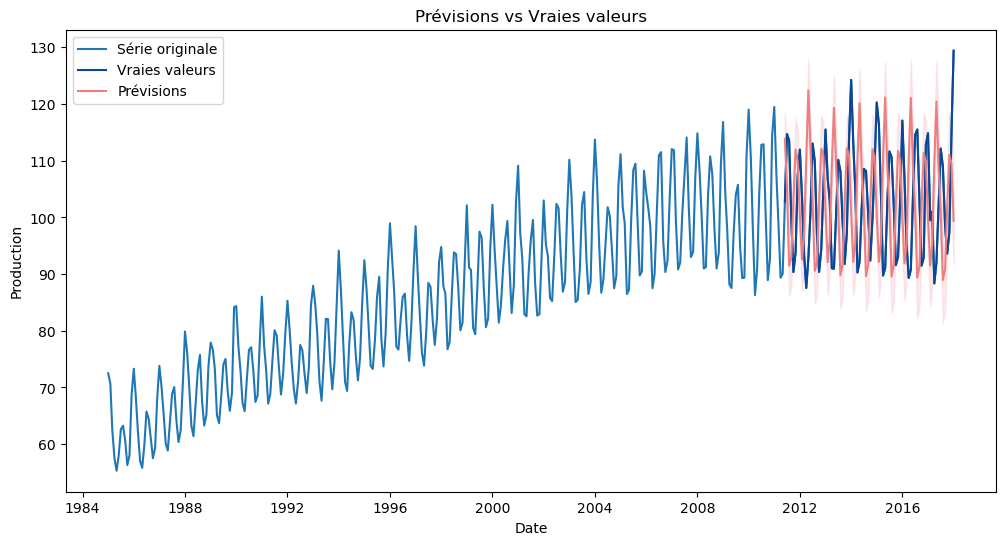

In [210]:
forecast_index = test.index

plt.figure(figsize=(12,6))
plt.plot(df["Production"], label='Série originale')
plt.plot(forecast_index, y_true, label='Vraies valeurs', color='#0B4699')
plt.plot(forecast_index, y_pred, label='Prévisions', color='#EC8081')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='#F6BAC4', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Production")
plt.title("Prévisions vs Vraies valeurs")
plt.legend()
plt.show()


### Conclusion

 >Le modèle SARIMA fournit des prévisions cohérentes et réalistes avec un bon niveau de précision. Les performances mesurées par les métriques (MAE, RMSE, MAPE) confirment une précision acceptable.

## Conclusion Générale

 >Dans ce projet, la méthode Box-Jenkins a été rigoureusement appliquée pour modéliser et prévoir la production d'électricité. Cette méthode se base sur un processus en trois étapes : identification du modèle, estimation des paramètres, et validation via l'analyse des résidus. Le modèle SARIMA(1,1,1)(2,1,2)[12] a été choisi pour sa capacité à capturer les tendances et la saisonnalité annuelle des données.

 >Les prévisions produites par le modèle suivent bien la tendance générale des données historiques, avec des performances mesurées par des indicateurs comme le MAE (13.76), le RMSE (15.75) et le MAPE (13.60%). Ces résultats indiquent que le modèle est globalement fiable pour prévoir la production future.